# Proyecto Individual 02 de Henry por Guillermo Fernandez

#### Importar librerías necesarias

In [134]:
# Librería para trabajar con los datasets
import pandas as pd
import numpy as np

# Módulo para trabajar con rutas de archivo
from pathlib import Path

# Librería para identificar encondings
import chardet

# Módulos para realizar modelos de Machine Learning
from sklearn import preprocessing as pp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Módulos para medir los modelos
from sklearn.metrics import classification_report

# Librerías para visualizar gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#### Crear una función para importar los datasets

In [2]:
# Para importar archivos csv, detectando encoding
def upload(filepath):
    with open(filepath, 'rb') as file:
        result = chardet.detect(file.read())
        DF = pd.read_csv(filepath, encoding=result['encoding'])
    return DF

#### Cargar y explorar el dataset

In [3]:
# Cargamos ambos datasets
Train_df = upload(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\hospitalizaciones_train.csv')
Test_df = upload(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\hospitalizaciones_test.csv')

In [4]:
# Aplicamos una función para renombrar las columnas, reemplazando espacios por guión bajo, y aplicando minúsculas
Train_df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)
Test_df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)

In [5]:
# Guardamos el original y trabajamos con una copia
Train_original = Train_df
Test_original = Test_df

In [6]:
# Tomamos una fila al azar para analizarlo
Train_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit,stay_(in_days)
296416,5,anesthesia,C,Dr Mark,7,97462,61-70,Male,Emergency,Moderate,Diabetes,4,No,4473.296295,31


In [7]:
Test_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit
50008,2,anesthesia,A,Dr John,4,30381,41-50,Female,Trauma,Extreme,Other,2,No,4452.44853


In [8]:
# Evaluamos información del dataset, como Dtype y nulos
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   available_extra_rooms_in_hospital  410000 non-null  int64  
 1   department                         410000 non-null  object 
 2   ward_facility_code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   type_of_admission                  410000 non-null  object 
 9   severity_of_illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  visitors_with_patient              4100

In [9]:
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   available_extra_rooms_in_hospital  90000 non-null  int64  
 1   department                         90000 non-null  object 
 2   ward_facility_code                 90000 non-null  object 
 3   doctor_name                        90000 non-null  object 
 4   staff_available                    90000 non-null  int64  
 5   patientid                          90000 non-null  int64  
 6   age                                90000 non-null  object 
 7   gender                             90000 non-null  object 
 8   type_of_admission                  90000 non-null  object 
 9   severity_of_illness                90000 non-null  object 
 10  health_conditions                  90000 non-null  object 
 11  visitors_with_patient              90000 non-null  int

### Data Preprocessing

#### Revisar features

In [10]:
# Eliminamos los datos duplicados
Train_df.drop_duplicates();
Test_df.drop_duplicates();

In [11]:
# Agregamos el feature que nos interesa predecir, si la estadía es prolongada
Train_df['long_stay'] = (Train_df['stay_(in_days)'] > 8)
Train_df['long_stay'].astype(str).replace({False: 0, True: 1})
Train_df['long_stay'] = Train_df['long_stay'].astype(int)

In [12]:
Train_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit,stay_(in_days),long_stay
31275,3,TB & Chest disease,A,Dr Mark,8,114600,51-60,Male,Trauma,Moderate,None,2,Yes,4482.353451,32,1


In [13]:
# Revisamos la cantidad de valores del feature agregado
Train_df.long_stay.value_counts()

1    255416
0    154584
Name: long_stay, dtype: int64

In [14]:
# Revisamos que las features en ambos datasets sean iguales
for elem in list(Test_df.columns):
    print(f'{elem}')
    unicos_train, unicos_test = Train_df[elem].sort_values().unique(), Test_df[elem].sort_values().unique()
    print(f'        Train: {len(unicos_train)} {unicos_train}')
    print(f'        Test:  {len(unicos_test)} {unicos_test}')
    print(f'Son iguales: {unicos_test.all() == unicos_train.all()}')

available_extra_rooms_in_hospital
        Train: 18 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 24]
        Test:  18 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 24]
Son iguales: True
department
        Train: 5 ['TB & Chest disease' 'anesthesia' 'gynecology' 'radiotherapy' 'surgery']
        Test:  5 ['TB & Chest disease' 'anesthesia' 'gynecology' 'radiotherapy' 'surgery']
Son iguales: True
ward_facility_code
        Train: 6 ['A' 'B' 'C' 'D' 'E' 'F']
        Test:  6 ['A' 'B' 'C' 'D' 'E' 'F']
Son iguales: True
doctor_name
        Train: 9 ['Dr Isaac' 'Dr John' 'Dr Mark' 'Dr Nathan' 'Dr Olivia' 'Dr Sam'
 'Dr Sarah' 'Dr Simon' 'Dr Sophia']
        Test:  9 ['Dr Isaac' 'Dr John' 'Dr Mark' 'Dr Nathan' 'Dr Olivia' 'Dr Sam'
 'Dr Sarah' 'Dr Simon' 'Dr Sophia']
Son iguales: True
staff_available
        Train: 11 [ 0  1  2  3  4  5  6  7  8  9 10]
        Test:  11 [ 0  1  2  3  4  5  6  7  8  9 10]
Son iguales: True
patientid
        Train: 122394 [ -3146  -3136  -3027 ... 13

#### Analizar la correlación con el feature de interés

In [15]:
# Modificamos una variable categórica a numérica
Train_df.insurance.replace({'No': 0, 'Yes': 1}, inplace = True, regex = True)
Test_df.insurance.replace({'No': 0, 'Yes': 1}, inplace = True, regex = True)

In [16]:
# Creamos columnas dummy para las variables categóricas
Train_df = pd.get_dummies(Train_df, columns = ['department', 'ward_facility_code', 'doctor_name', 'age', 'gender', 'type_of_admission', 'severity_of_illness', 'health_conditions'])
Test_df = pd.get_dummies(Test_df, columns = ['department', 'ward_facility_code', 'doctor_name', 'age', 'gender', 'type_of_admission', 'severity_of_illness', 'health_conditions'])

In [17]:
# Evaluamos el resultado final, siendo que el DF de los test debería tener 2 columnas menos: stay_(in_days) y long_stay
print(Train_df.shape)
print(Test_df.shape)

(410000, 53)
(90000, 51)


In [18]:
# Revisamos el resultado en una celda cualquiera
Train_df.sample(1)

,available_extra_rooms_in_hospital,staff_available,patientid,visitors_with_patient,insurance,admission_deposit,stay_(in_days),long_stay,department_TB & Chest disease,department_anesthesia,...,type_of_admission_Urgent,severity_of_illness_Extreme,severity_of_illness_Minor,severity_of_illness_Moderate,health_conditions_Asthama,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_None,health_conditions_Other
25803,4,10,78396,4,1,3592.583458,9,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [19]:
# Evaluamos la correlación para la feature que nos interesa
Train_df.corr()['stay_(in_days)'].abs().sort_values(ascending=False)

stay_(in_days)                           1.000000
department_gynecology                    0.701218
gender_Female                            0.629616
department_anesthesia                    0.596150
gender_Male                              0.560633
doctor_name_Dr Mark                      0.535644
long_stay                                0.493378
ward_facility_code_E                     0.449489
age_61-70                                0.441602
ward_facility_code_A                     0.410231
age_51-60                                0.405965
age_71-80                                0.348840
doctor_name_Dr John                      0.302958
ward_facility_code_F                     0.269189
ward_facility_code_D                     0.263576
age_31-40                                0.257243
doctor_name_Dr Olivia                    0.244178
department_TB & Chest disease            0.241790
ward_facility_code_B                     0.241052
department_surgery                       0.234838


In [20]:
# Evaluamos la correlación para la versión categórica de la feature que nos interesa
Train_df.corr()['long_stay'].abs().sort_values(ascending=False)

long_stay                                1.000000
stay_(in_days)                           0.493378
doctor_name_Dr Mark                      0.246904
department_anesthesia                    0.242282
department_gynecology                    0.230424
gender_Female                            0.206991
gender_Male                              0.184325
age_61-70                                0.184272
age_51-60                                0.165409
department_TB & Chest disease            0.154842
age_71-80                                0.153605
ward_facility_code_A                     0.150734
age_31-40                                0.140341
ward_facility_code_E                     0.138988
ward_facility_code_F                     0.108095
age_81-90                                0.100105
doctor_name_Dr John                      0.099091
age_41-50                                0.092119
ward_facility_code_D                     0.081017
department_surgery                       0.078740


#### Utilizar otro método para revisar la correlación

In [32]:
LE = pp.LabelEncoder()
Train_2 = Train_original
Test_2 = Test_original

In [33]:
Train_2.department = LE.fit_transform(Train_2.department)
Train_2.ward_facility_code = LE.fit_transform(Train_2.ward_facility_code)
Train_2.doctor_name = LE.fit_transform(Train_2.doctor_name)
Train_2.age = LE.fit_transform(Train_2.age)
Train_2.gender = LE.fit_transform(Train_2.gender)
Train_2.type_of_admission = LE.fit_transform(Train_2.type_of_admission)
Train_2.severity_of_illness = LE.fit_transform(Train_2.severity_of_illness)
Train_2.health_conditions = LE.fit_transform(Train_2.health_conditions)
Train_2.insurance = LE.fit_transform(Train_2.insurance)

In [34]:
Test_2.department = LE.fit_transform(Test_2.department)
Test_2.ward_facility_code = LE.fit_transform(Test_2.ward_facility_code)
Test_2.doctor_name = LE.fit_transform(Test_2.doctor_name)
Test_2.age = LE.fit_transform(Test_2.age)
Test_2.gender = LE.fit_transform(Test_2.gender)
Test_2.type_of_admission = LE.fit_transform(Test_2.type_of_admission)
Test_2.severity_of_illness = LE.fit_transform(Test_2.severity_of_illness)
Test_2.health_conditions = LE.fit_transform(Test_2.health_conditions)
Test_2.insurance = LE.fit_transform(Test_2.insurance)

In [23]:
Train_2.corr()['stay_(in_days)'].abs().sort_values(ascending=False)

stay_(in_days)                       1.000000
gender                               0.589757
age                                  0.585201
long_stay                            0.493378
doctor_name                          0.444867
department                           0.204050
ward_facility_code                   0.145227
admission_deposit                    0.043899
type_of_admission                    0.035811
visitors_with_patient                0.027284
severity_of_illness                  0.024316
available_extra_rooms_in_hospital    0.019383
staff_available                      0.006673
patientid                            0.005567
health_conditions                    0.001772
insurance                            0.000947
Name: stay_(in_days), dtype: float64

In [27]:
Train_2.corr()['long_stay'].abs().sort_values(ascending=False)

long_stay                            1.000000
stay_(in_days)                       0.493378
age                                  0.229657
gender                               0.193878
department                           0.173021
doctor_name                          0.172526
ward_facility_code                   0.074337
available_extra_rooms_in_hospital    0.053894
severity_of_illness                  0.017030
admission_deposit                    0.016650
visitors_with_patient                0.009529
type_of_admission                    0.006233
staff_available                      0.002883
health_conditions                    0.002568
insurance                            0.001063
patientid                            0.000532
Name: long_stay, dtype: float64

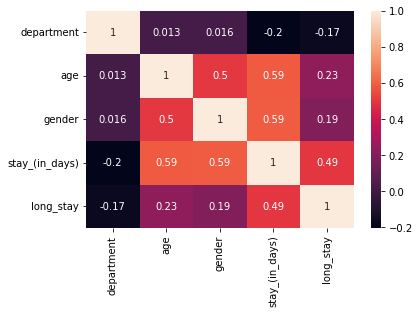

In [58]:
corr = Train_2.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True);

#### Eliminar features sin relevancia

In [24]:
# Tomamos la lista de columnas a eliminar
col_to_drop = list(Train_df.corr()['stay_(in_days)'].abs().sort_values(ascending=False).index[12:])

In [25]:
# Realizamos la eliminación
Train_df.drop(columns = col_to_drop, inplace = True)
Test_df.drop(columns = col_to_drop, inplace = True);

In [28]:
Train_df.sample(1)

,stay_(in_days),long_stay,department_anesthesia,department_gynecology,ward_facility_code_A,ward_facility_code_E,doctor_name_Dr Mark,age_51-60,age_61-70,age_71-80,gender_Female,gender_Male
6557,8,0,0,1,0,0,0,0,0,0,1,0


In [39]:
# Aplicamos lo mismo para el dataset que no tiene dummies
col_to_drop = list(Train_2.corr()['long_stay'].abs().sort_values(ascending=False).index[5:])

In [40]:
# Realizamos la eliminación
Train_2.drop(columns = col_to_drop, inplace = True)
Test_2.drop(columns = col_to_drop, inplace = True);

In [57]:
Train_2.sample(1)

,department,age,gender,stay_(in_days),long_stay
278397,2,1,0,9,1


## Modelado

### Árbol de desición - age_department

In [137]:
# Consideramos un árbol de desición para realizar la predicción
X = Train_2.drop(columns=['stay_(in_days)', 'long_stay', 'gender'])
y = Train_2.long_stay

In [99]:
# Realizamos una iteración para evaluar la profundidad óptima del árbol
tree_train_scores_mean = []
tree_train_scores_std = []

tree_test_scores_mean = []
tree_test_scores_std = []
# Consideramos 20 como profundidad máxima
profundidades = np.arange(1,20,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad,criterion="entropy")
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

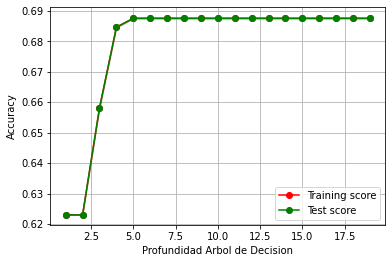

In [100]:
# Ploteamos los resultados
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

##### De acuerdo a lo ensayado, tomar la profundidad óptima y medir

In [138]:
clf = DecisionTreeClassifier(max_depth=5,criterion="entropy")
clf.fit(X.values, y.values)
y_pred = clf.predict(X.values)

In [139]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29    154584
           1       0.67      1.00      0.80    255416

    accuracy                           0.69    410000
   macro avg       0.83      0.59      0.55    410000
weighted avg       0.79      0.69      0.61    410000



### Árbol de desición - age_gender

In [123]:
# Consideramos un árbol de desición para realizar la predicción
X = Train_2.drop(columns=['stay_(in_days)', 'long_stay', 'department'])
y = Train_2.long_stay

In [94]:
# Realizamos una iteración para evaluar la profundidad óptima del árbol
tree_train_scores_mean = []
tree_train_scores_std = []

tree_test_scores_mean = []
tree_test_scores_std = []
# Consideramos 20 como profundidad máxima
profundidades = np.arange(1,20,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad,criterion="entropy")
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

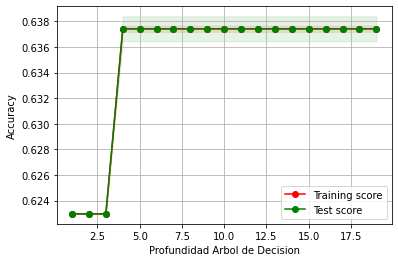

In [95]:
# Ploteamos los resultados
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

##### De acuerdo a lo ensayado, tomar la profundidad óptima y medir

In [135]:
clf = DecisionTreeClassifier(max_depth=4,criterion="entropy")
clf.fit(X.values, y.values)
y_pred = clf.predict(X.values)

In [136]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.17      0.29    154584
           1       0.66      1.00      0.80    255416

    accuracy                           0.68    410000
   macro avg       0.81      0.58      0.54    410000
weighted avg       0.77      0.68      0.61    410000



### Árbol de desición - gender_department

In [126]:
# Consideramos un árbol de desición para realizar la predicción
X = Train_2.drop(columns=['stay_(in_days)', 'long_stay', 'age'])
y = Train_2.long_stay

In [104]:
# Realizamos una iteración para evaluar la profundidad óptima del árbol
tree_train_scores_mean = []
tree_train_scores_std = []

tree_test_scores_mean = []
tree_test_scores_std = []
# Consideramos 20 como profundidad máxima
profundidades = np.arange(1,20,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad,criterion="entropy")
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

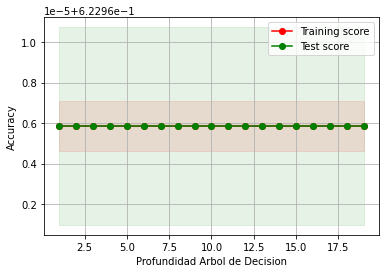

In [105]:
# Ploteamos los resultados
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

##### De acuerdo a lo ensayado, tomar la profundidad óptima y medir

In [127]:
clf = DecisionTreeClassifier(max_depth=2,criterion="entropy")
clf.fit(X.values, y.values)
y_pred = clf.predict(X.values)

In [128]:
print(classification_report(y, y_pred))

c:\Users\eugen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\eugen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    154584
           1       0.62      1.00      0.77    255416

    accuracy                           0.62    410000
   macro avg       0.31      0.50      0.38    410000
weighted avg       0.39      0.62      0.48    410000



c:\Users\eugen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Predicción

In [141]:
# Entrenamos nuevamente el modelo con el dataset Train
X = Train_2.drop(columns=['stay_(in_days)', 'long_stay', 'gender'])
y = Train_2.long_stay
clf = DecisionTreeClassifier(max_depth=5,criterion="entropy")
clf.fit(X.values, y.values)
# Y realizamos la predicción para el dataset Test
X = Test_2.drop(columns=['gender'])
y_pred = clf.predict(X.values)

In [156]:
# Evaluamos la cantidad de datos
y_pred.shape

(90000,)

In [145]:
# Asignamos los datos al dataset
Test_2['pred'] = y_pred

In [155]:
# Revisamos los resultados obtenidos
Test_2.sample(5)

,department,age,gender,pred
62748,3,4,0,0
85184,2,4,0,1
27617,2,2,0,1
72431,2,4,0,1
51880,2,1,0,1


In [157]:
# Tomamos únicamente la columna con las predicciones
result = Test_2.pred

In [161]:
# Exportamos la columna a un csv de acuerdo a la consigna del proyecto
result.to_csv(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\fernandezguille.csv', index=False)